In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv("Heart.csv")
df = df.drop(columns=["Unnamed: 0"])  # Drop unnecessary index column

# Describe the original dataset before preprocessing
print("\nSummary statistics before preprocessing:\n")
original_summary_stats = df.describe(include="all")
print(original_summary_stats)



Summary statistics before preprocessing:

               Age         Sex     ChestPain      RestBP        Chol  \
count   303.000000  303.000000           303  303.000000  303.000000   
unique         NaN         NaN             4         NaN         NaN   
top            NaN         NaN  asymptomatic         NaN         NaN   
freq           NaN         NaN           144         NaN         NaN   
mean     54.438944    0.679868           NaN  131.689769  246.693069   
std       9.038662    0.467299           NaN   17.599748   51.776918   
min      29.000000    0.000000           NaN   94.000000  126.000000   
25%      48.000000    0.000000           NaN  120.000000  211.000000   
50%      56.000000    1.000000           NaN  130.000000  241.000000   
75%      61.000000    1.000000           NaN  140.000000  275.000000   
max      77.000000    1.000000           NaN  200.000000  564.000000   

               Fbs     RestECG       MaxHR       ExAng     Oldpeak  \
count   303.000000  30

In [18]:
# Remove missing values
df_clean = df.dropna()

# Encode categorical variable
# AHD: Heart disease status (No -> 0, Yes -> 1)
df_clean.loc[:, "AHD"] = df_clean["AHD"].map({"No": 0, "Yes": 1})

# Convert ChestPain and Thal into dummy variables (one-hot encoding)
df_clean = pd.get_dummies(df_clean, columns=["ChestPain", "Thal"], drop_first=True)

# Standardize numerical variables (mean = 0, std = 1)
scaler = StandardScaler()
columns_to_scale = ["RestBP", "Chol", "MaxHR"]
df_clean[columns_to_scale] = scaler.fit_transform(df_clean[columns_to_scale])

# Display summary statistics after preprocessing
print("\nSummary statistics after preprocessing:\n")
summary_stats = df_clean.describe()
print(summary_stats)




Summary statistics after preprocessing:

              Age         Sex        RestBP          Chol         Fbs  \
count  297.000000  297.000000  2.970000e+02  2.970000e+02  297.000000   
mean    54.542088    0.676768  4.904420e-16 -1.958777e-16    0.144781   
std      9.049736    0.468500  1.001688e+00  1.001688e+00    0.352474   
min     29.000000    0.000000 -2.125634e+00 -2.337704e+00    0.000000   
25%     48.000000    0.000000 -6.594306e-01 -7.002541e-01    0.000000   
50%     56.000000    1.000000 -9.550637e-02 -8.380217e-02    0.000000   
75%     61.000000    1.000000  4.684179e-01  5.519138e-01    0.000000   
max     77.000000    1.000000  3.851964e+00  6.099981e+00    1.000000   

          RestECG         MaxHR       ExAng     Oldpeak       Slope  \
count  297.000000  2.970000e+02  297.000000  297.000000  297.000000   
mean     0.996633  4.784800e-16    0.326599    1.055556    1.602694   
std      0.994914  1.001688e+00    0.469761    1.166123    0.618187   
min      0.00000

In [19]:
X = df_clean.drop("AHD", axis=1)
y = df_clean["AHD"]

# Convert to NumPy format to avoid potential incompatibility with some sklearn algorithms
X = X.to_numpy().astype(np.float64)
y = y.to_numpy().astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Build classifiers

results = {}

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = log_reg.predict(X_test)
results["Logistic Regression"] = {
    "model": log_reg,
    "y_pred": y_pred_lr,
    "y_prob": y_prob_lr,
    "confusion": confusion_matrix(y_test, y_pred_lr),
    "accuracy": accuracy_score(y_test, y_pred_lr)
}

# KNN with best k via GridSearchCV
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, {"n_neighbors": range(1, 21)}, cv=5)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]
y_pred_knn = best_knn.predict(X_test)
results["KNN"] = {
    "model": best_knn,
    "y_pred": y_pred_knn,
    "y_prob": y_prob_knn,
    "confusion": confusion_matrix(y_test, y_pred_knn),
    "accuracy": accuracy_score(y_test, y_pred_knn),
    "best_k": grid_knn.best_params_["n_neighbors"]
}

# Random Forest with best params
rf = RandomForestClassifier(random_state=42)
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10, None]}
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)
results["Random Forest"] = {
    "model": best_rf,
    "y_pred": y_pred_rf,
    "y_prob": y_prob_rf,
    "confusion": confusion_matrix(y_test, y_pred_rf),
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "best_params": grid_rf.best_params_
}


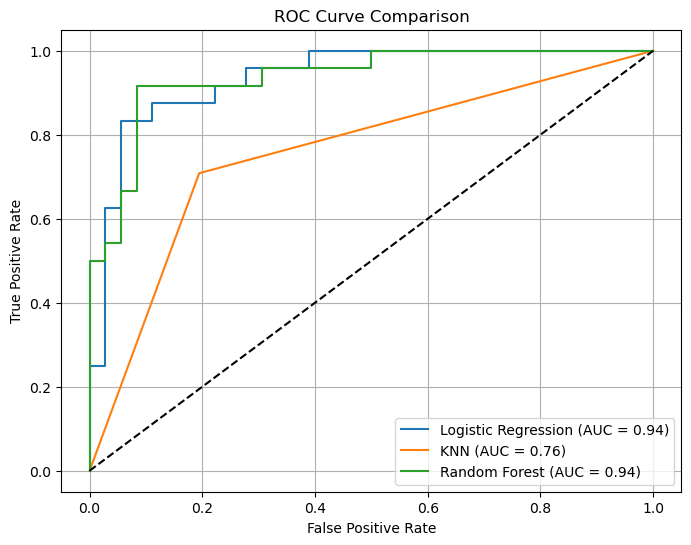

In [21]:
# Plot ROC curves for comparison

plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


In [22]:
# Output confusion matrices and accuracy scores

for name, res in results.items():
    print(f"\n{name}")
    print("Best Params:" if "best_k" in res or "best_params" in res else "", res.get("best_k", res.get("best_params", "")))
    print("Confusion Matrix:\n", res["confusion"])
    print("Accuracy: {:.3f}".format(res["accuracy"]))


Logistic Regression
 
Confusion Matrix:
 [[32  4]
 [ 4 20]]
Accuracy: 0.867

KNN
Best Params: 1
Confusion Matrix:
 [[29  7]
 [ 7 17]]
Accuracy: 0.767

Random Forest
Best Params: {'max_depth': 3, 'n_estimators': 200}
Confusion Matrix:
 [[33  3]
 [ 3 21]]
Accuracy: 0.900


In [23]:
# Predict heart disease for a new patient

# Manually construct the new patient's features (in the same order as training data)
new_patient = {
    "Age": 55,
    "Sex": 0,
    "RestBP": 130,
    "Chol": 246,
    "Fbs": 0,
    "RestECG": 2,
    "MaxHR": 150,
    "ExAng": 1,
    "Oldpeak": 1,
    "Slope": 2,
    "Ca": 0,
    # ChestPain: typical
    "ChestPain_nonanginal": 0,
    "ChestPain_nontypical": 0,
    "ChestPain_typical": 1,
    # Thal: normal
    "Thal_normal": 1,
    "Thal_reversable": 0
}

# Convert to DataFrame
new_df = pd.DataFrame([new_patient])

# Standardize RestBP, Chol, MaxHR using the original scaler
new_df[["RestBP", "Chol", "MaxHR"]] = scaler.transform(new_df[["RestBP", "Chol", "MaxHR"]])

# Convert to NumPy array
X_new = new_df.to_numpy().astype(np.float64)

# Use the best model selected
best_model = results["Random Forest"]["model"]  

# Predict class (0 = No heart disease, 1 = Has heart disease)
pred_class = best_model.predict(X_new)[0]
pred_prob = best_model.predict_proba(X_new)[0][1]  # Get probability of heart disease

# Print the result
print("Prediction result:")
if pred_class == 1:
    print("The patient is predicted to HAVE heart disease (probability = {:.2f})".format(pred_prob))
else:
    print("The patient is predicted to NOT have heart disease (probability = {:.2f})".format(pred_prob))


Prediction result:
The patient is predicted to NOT have heart disease (probability = 0.30)
